In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# Constants
DATASET_PATH = '/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset'
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = 128, 128
SEQ_LEN = 5
NUM_CLASSES = 62

# Character mapping (0-61 -> 'A'-'Z', 'a'-'z', '0'-'9')
CHARACTERS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [2]:
# Convert a single character to a one-hot encoded vector
def char_to_onehot(char):
    onehot = np.zeros(NUM_CLASSES, dtype=np.float32)
    onehot[CHARACTERS.index(char)] = 1.0
    return onehot

# Convert a full text (captcha) to a flattened one-hot encoded vector
def text_to_onehot(text):
    matrix = np.zeros((SEQ_LEN, NUM_CLASSES), dtype=np.float32)
    for i, char in enumerate(text):
        matrix[i] = char_to_onehot(char)
    return matrix.flatten()  # 62*7 = 434 vector

In [3]:
from tqdm import tqdm  # Import tqdm for the progress bar

class CaptchaDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.samples = []
        
        print("Loading dataset...")
        for fname in tqdm(os.listdir(data_path), desc="Processing files"):
            img_path = os.path.join(data_path, fname)
            label = fname.split('.')[0]
            try:
                # Check if the file can be opened successfully
                with Image.open(img_path) as img:
                    img.verify()  # Verify if the image is not corrupted
                self.samples.append((img_path, label))
            except (IOError, SyntaxError) as e:
                print(f"Skipping corrupted file: {fname}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_onehot = text_to_onehot(label)
        return image, torch.tensor(label_onehot, dtype=torch.float32)

In [4]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CaptchaDataset(DATASET_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

Loading dataset...


Processing files:  44%|████▍     | 36181/82329 [04:44<08:09, 94.18it/s] 

Skipping corrupted file: 4q2wA.png


Processing files: 100%|██████████| 82329/82329 [11:56<00:00, 114.91it/s]


In [5]:
class CaptchaSolver(nn.Module):
    def __init__(self):
        super(CaptchaSolver, self).__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove ResNet's classification head
        self.fc = nn.Linear(2048, SEQ_LEN * NUM_CLASSES)  # 62*7 = 434
        
    def forward(self, x):
        features = self.backbone(x)
        out = self.fc(features)
        return out.view(-1, SEQ_LEN, NUM_CLASSES)  # Reshape for sequence output

In [6]:
from tqdm import tqdm
import torch
import torch.nn as nn
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CaptchaSolver().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def validate(model, loader, criterion):
    """
    Validate the model on a validation set and calculate accuracy.
    
    Args:
        model (nn.Module): Trained model.
        loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
    
    Returns:
        tuple: Validation loss, character-level accuracy, captcha-level accuracy.
    """
    model.eval()
    total_loss = 0.0
    total_chars = 0
    correct_chars = 0
    total_captchas = 0
    correct_captchas = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, SEQ_LEN, NUM_CLASSES)
            
            outputs = model(images)
            
            # Calculate loss
            loss = 0.0
            for i in range(SEQ_LEN):
                loss += criterion(outputs[:, i, :], labels[:, i, :].argmax(dim=1))
            total_loss += loss.item()
            
            # Calculate character-level accuracy
            for i in range(SEQ_LEN):
                predictions = outputs[:, i, :].argmax(dim=1)
                targets = labels[:, i, :].argmax(dim=1)
                correct_chars += (predictions == targets).sum().item()
                total_chars += predictions.size(0)
            
            # Calculate captcha-level accuracy
            for i in range(outputs.size(0)):  # Iterate over batch
                predicted_text = "".join(
                    CHARACTERS[outputs[i, j, :].argmax().item()] for j in range(SEQ_LEN)
                )
                true_text = "".join(
                    CHARACTERS[labels[i, j, :].argmax().item()] for j in range(SEQ_LEN)
                )
                if predicted_text == true_text:
                    correct_captchas += 1
                total_captchas += 1
    
    char_accuracy = correct_chars / total_chars
    captcha_accuracy = correct_captchas / total_captchas
    return total_loss / len(loader), char_accuracy, captcha_accuracy


def train(model, train_loader, val_loader, criterion, optimizer, epochs=20, model_path="captcha_solver.pth"):
    """
    Train the model with early stopping and save the best model based on validation loss.
    
    Args:
        model (nn.Module): Model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of epochs.
        patience (int): Number of epochs to wait for improvement before stopping.
        model_path (str): Path to save the best model.
    """
    best_val_loss = float('inf')
    no_improvement_epochs = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training", leave=False)
        
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, SEQ_LEN, NUM_CLASSES)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = 0.0
            for i in range(SEQ_LEN):
                loss += criterion(outputs[:, i, :], labels[:, i, :].argmax(dim=1))
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            train_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        # Validation
        val_loss, char_acc, captcha_acc = validate(model, val_loader, criterion)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with val_loss: {val_loss:.4f}")
        else:
            no_improvement_epochs += 1
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss:.4f}, Char Accuracy: {char_acc:.4f}, Captcha Accuracy: {captcha_acc:.4f}")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [7]:
# Train the model
train(model, train_loader, val_loader, criterion, optimizer, epochs=20)

Saved best model with val_loss: 12.0047

Epoch 1/20
Train Loss: 17.5493
Val Loss: 12.0047, Char Accuracy: 0.3460, Captcha Accuracy: 0.0032


Saved best model with val_loss: 2.9805

Epoch 2/20
Train Loss: 6.5295
Val Loss: 2.9805, Char Accuracy: 0.8005, Captcha Accuracy: 0.3205


Saved best model with val_loss: 1.4248

Epoch 3/20
Train Loss: 2.3122
Val Loss: 1.4248, Char Accuracy: 0.9040, Captcha Accuracy: 0.6048


Saved best model with val_loss: 0.9411

Epoch 4/20
Train Loss: 1.3016
Val Loss: 0.9411, Char Accuracy: 0.9404, Captcha Accuracy: 0.7388


Saved best model with val_loss: 0.6469

Epoch 5/20
Train Loss: 0.9394
Val Loss: 0.6469, Char Accuracy: 0.9588, Captcha Accuracy: 0.8122


Saved best model with val_loss: 0.4570

Epoch 6/20
Train Loss: 0.7663
Val Loss: 0.4570, Char Accuracy: 0.9714, Captcha Accuracy: 0.8663



Epoch 7/20
Train Loss: 0.6604
Val Loss: 0.5209, Char Accuracy: 0.9699, Captcha Accuracy: 0.8598


Saved best model with val_loss: 0.4400

Epoch 8/20
Train Loss: 0.5986
Val Loss: 0.4400, Char Accuracy: 0.9748, Captcha Accuracy: 0.8812


Saved best model with val_loss: 0.3500

Epoch 9/20
Train Loss: 0.5350
Val Loss: 0.3500, Char Accuracy: 0.9797, Captcha Accuracy: 0.9029



Epoch 10/20
Train Loss: 0.4973
Val Loss: 0.4034, Char Accuracy: 0.9771, Captcha Accuracy: 0.8915



Epoch 11/20
Train Loss: 0.4679
Val Loss: 0.3928, Char Accuracy: 0.9780, Captcha Accuracy: 0.8966


Saved best model with val_loss: 0.3437

Epoch 12/20
Train Loss: 0.4412
Val Loss: 0.3437, Char Accuracy: 0.9800, Captcha Accuracy: 0.9050



Epoch 13/20
Train Loss: 0.4131
Val Loss: 0.3543, Char Accuracy: 0.9797, Captcha Accuracy: 0.9023



Epoch 14/20
Train Loss: 0.4026
Val Loss: 0.4862, Char Accuracy: 0.9732, Captcha Accuracy: 0.8783


Saved best model with val_loss: 0.2563

Epoch 15/20
Train Loss: 0.3917
Val Loss: 0.2563, Char Accuracy: 0.9849, Captcha Accuracy: 0.9275


Saved best model with val_loss: 0.2329

Epoch 16/20
Train Loss: 0.3763
Val Loss: 0.2329, Char Accuracy: 0.9869, Captcha Accuracy: 0.9366



Epoch 17/20
Train Loss: 0.3627
Val Loss: 0.3141, Char Accuracy: 0.9820, Captcha Accuracy: 0.9144



Epoch 18/20
Train Loss: 0.3459
Val Loss: 0.2836, Char Accuracy: 0.9841, Captcha Accuracy: 0.9234



Epoch 19/20
Train Loss: 0.3453
Val Loss: 0.2644, Char Accuracy: 0.9853, Captcha Accuracy: 0.9296



Epoch 20/20
Train Loss: 0.3332
Val Loss: 0.2450, Char Accuracy: 0.9861, Captcha Accuracy: 0.9328


In [8]:
def predict_captcha(model, image, transform):
    """
    Predict the text of a captcha image using the trained model.
    
    Args:
        model (nn.Module): Trained model.
        image (PIL.Image): Input captcha image.
        transform (torchvision.transforms): Transformations to apply to the image.
    
    Returns:
        str: Decrypted captcha text.
    """
    model.eval()
    with torch.no_grad():
        if transform:
            image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        output = model(image)  # Forward pass
        output = output.squeeze(0)  # Remove batch dimension
        
        # Decode the predicted output
        predicted_text = ""
        for i in range(SEQ_LEN):
            char_idx = output[i].argmax().item()
            predicted_text += CHARACTERS[char_idx]
        return predicted_text

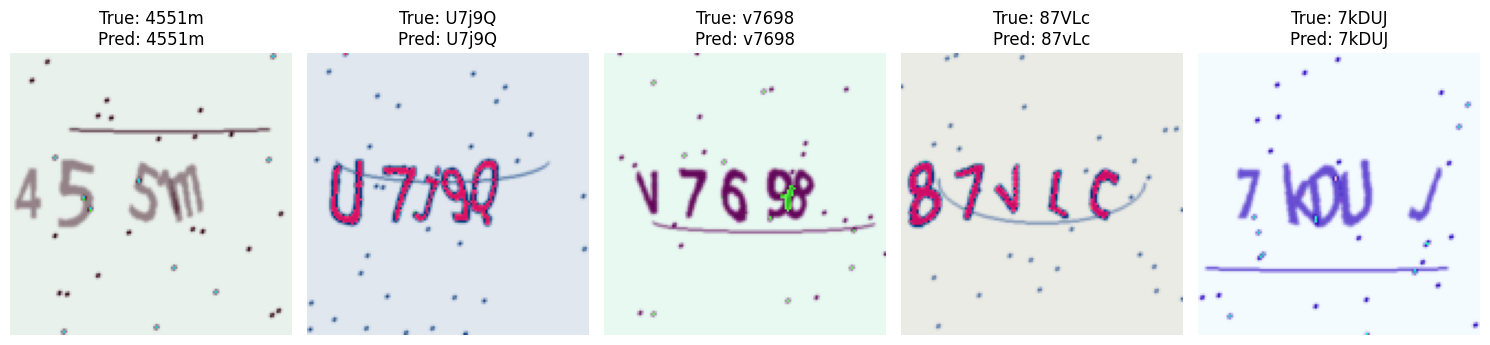

In [17]:
import matplotlib.pyplot as plt
import random

# Plot examples
def plot_examples(model, dataset, num_examples=5):
    """
    Plot captcha examples along with the model's predictions.
    
    Args:
        model (nn.Module): Trained model.
        dataset (Dataset): Captcha dataset.
        num_examples (int): Number of examples to plot.
    """
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for i in range(num_examples):
        idx = random.randint(0, len(dataset) - 1)
        image, label_onehot = dataset[idx]
        label = "".join(
            CHARACTERS[onehot.argmax().item()] for onehot in label_onehot.view(SEQ_LEN, NUM_CLASSES)
        )
        
        predicted_text = predict_captcha(model, transforms.ToPILImage()(image), transform)
        
        axes[i].imshow(transforms.ToPILImage()(image))
        axes[i].set_title(f"True: {label}\nPred: {predicted_text}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

plot_examples(model, val_subset, num_examples=5)